In [1]:
from PlateDetect import Detect
from PlateSegmenting import Segmenting
from PerspectivePlate import Perspective
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
import cv2
import numpy as np

YOLOv5 🚀 v6.0-16-g6d9b99f torch 1.9.1+cu102 CPU

Fusing layers... 
Model Summary: 316 layers, 21472671 parameters, 0 gradients
Adding AutoShape... 


In [91]:
def ShowImage(images):
    fig= plt.figure(figsize=(10, 7))
    rows= 2; columns= 2
    for i,img in enumerate(images):
        fig.add_subplot(rows, columns, i+1)
        plt.imshow(img, cmap="gray")

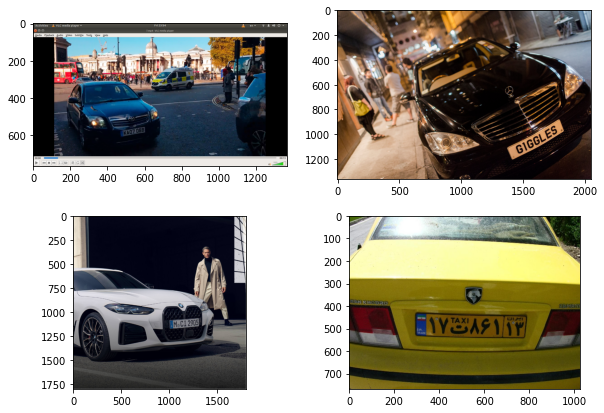

In [92]:
folder= 'yolov5/image/'
names= ['car0001.png', 'car13.jpg', 'car24.jpg', '215.jpg']

images= []
for name in names:
    image = cv2.imread(folder+name)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    images.append(image)
    
ShowImage(images)

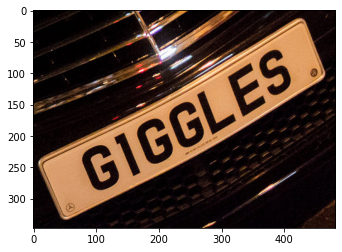

In [93]:
plate= images[1].copy()
pts= Detect(plate)
x,y,w,h, _, _= pts[0]
xplate= plate[y:h, x:w]
plt.imshow(xplate, cmap="gray")

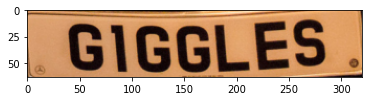

In [94]:
plate_pers= Perspective(xplate)
plt.imshow(plate_pers, cmap="gray")

In [95]:
m= Segmenting(plate_pers)

(64, 59, 3)


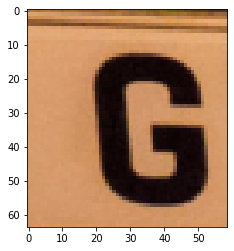

In [96]:
width = 75
height = 100
img_plate=m[2]
# img_platex= blur = cv2.GaussianBlur(cv2.cvtColor(m[2], cv2.COLOR_RGB2GRAY), (5, 5), 0)
# img_plate= cv2.resize(img_platex, (width, height))
plt.imshow(img_plate, cmap="gray")
print(img_plate.shape)

# Predictions

In [97]:
# characterRecognition = tf.keras.models.load_model('yolov5/weights/character_recognition.h5')
characterRecognition = tf.keras.models.load_model('yolov5/weights/model_char_en_recognition1000.h5')

In [98]:
def cnnCharRecognition(img):
    dictionary = {0:'0', 1:'1', 2 :'2', 3:'3', 4:'4', 5:'5', 6:'6', 7:'7', 8:'8', 9:'9', 10:'A',
    11:'B', 12:'C', 13:'D', 14:'E', 15:'F', 16:'G', 17:'H', 18:'I', 19:'J', 20:'K',
    21:'L', 22:'M', 23:'N', 24:'P', 25:'Q', 26:'R', 27:'S', 28:'T', 29:'U',
    30:'V', 31:'W', 32:'X', 33:'Y', 34:'Z'}

    blackAndWhiteChar=cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blackAndWhiteChar = cv2.resize(blackAndWhiteChar,(75,100))
    image = blackAndWhiteChar.reshape((1, 100,75, 1))
    image = image / 255.0
    new_predictions = characterRecognition.predict(image)
    char = np.argmax(new_predictions)
    return dictionary[char]

In [99]:
def auto_canny(image, sigma=0.33):
    v = np.median(image)  # compute the median of the single channel pixel intensities

    # apply automatic Canny edge detection using the computed median
    lower = int(max(0, (1.0 - sigma) * v))
    upper = int(min(255, (1.0 + sigma) * v))
    edged = cv2.Canny(image, lower, upper)
    return edged

In [100]:
def opencvReadPlate(img):
    charList=[]
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    gray = cv2.cvtColor(plate_pers,cv2.COLOR_BGR2GRAY)
#     gray = cv2.GaussianBlur(gray, (3, 3), 0)
#     clahe= cv2.createCLAHE(clipLimit=2.0,  tileGridSize=(3,3))
#     gray= clahe.apply(gray)
    
    thresh_inv = cv2.adaptiveThreshold(gray,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY_INV,39,1)
    edges = auto_canny(thresh_inv)
    ctrs, _ = cv2.findContours(edges.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    sorted_ctrs = sorted(ctrs, key=lambda ctr: cv2.boundingRect(ctr)[0])
    img_area = img.shape[0]*img.shape[1]

    for i, ctr in enumerate(sorted_ctrs):
        x, y, w, h = cv2.boundingRect(ctr)
        roi_area = w*h
        non_max_sup = roi_area/img_area

        if((non_max_sup >= 0.015) and (non_max_sup < 0.09)):
            if ((h>1.2*w) and (3*w>=h)):
                char = img[y:y+h,x:x+w]
                char = cv2.GaussianBlur(char, (3, 3), 0)
#                 clahe= cv2.createCLAHE(clipLimit=5.0,  tileGridSize=(5,5))
#                 gray= clahe.apply(char)
                charList.append(cnnCharRecognition(char))
                cv2.rectangle(img,(x,y),( x + w, y + h ),(90,0,255),1)

    plt.imshow(img, cmap="gray")
    licensePlate="".join(charList)
    return licensePlate, img

GIGGLES


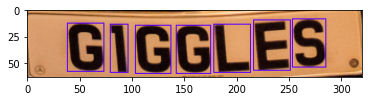

In [101]:
text, img= opencvReadPlate(plate_pers.copy())
print(text)